### Counterfactual explanations on Categorical data - uses Adult Dataset and OneHotEncoder
##### https://docs.seldon.io/projects/alibi/en/latest/examples/cfproto_cat_adult_ohe.html
### 25th August 2020

In [52]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from time import time
from alibi.datasets import fetch_adult
from alibi.explainers import CounterFactualProto
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.3.0
Eager execution enabled:  False


In [53]:
adult = fetch_adult()
data = adult.data
target = adult.target
feature_names = adult.feature_names
category_map_tmp = adult.category_map
target_names = adult.target_names

In [54]:
def set_seed(s=0):
    np.random.seed(s)
    tf.random.set_seed(s)

In [55]:
set_seed()
data_perm = np.random.permutation(np.c_[data, target])
X = data_perm[:,:-1]
y = data_perm[:,-1]

In [56]:
idx = 30000
y_train, y_test = y[:idx], y[idx+1:]

In [57]:
X = np.c_[X[:, 1:8], X[:, 11], X[:, 0], X[:, 8:11]]

In [58]:
feature_names = feature_names[1:8] + feature_names[11:12] + feature_names[0:1] + feature_names[8:11]
print(feature_names)

['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Age', 'Capital Gain', 'Capital Loss', 'Hours per week']


In [59]:
category_map = {}
for i, (_, v) in enumerate(category_map_tmp.items()):
    category_map[i] = v

In [60]:
cat_vars_ord = {}
n_categories = len(list(category_map.keys()))
for i in range(n_categories):
    cat_vars_ord[i] = len(np.unique(X[:, i]))
print(cat_vars_ord)

{0: 9, 1: 7, 2: 4, 3: 9, 4: 6, 5: 5, 6: 2, 7: 11}


In [61]:
cat_vars_ohe = ord_to_ohe(X, cat_vars_ord)[1]
print(cat_vars_ohe)

{0: 9, 9: 7, 16: 4, 20: 9, 29: 6, 35: 5, 40: 2, 42: 11}


In [62]:
X_num = X[:, -4:].astype(np.float32, copy=False)
xmin, xmax = X_num.min(axis=0), X_num.max(axis=0)
rng = (-1., 1.)
X_num_scaled = (X_num - xmin) / (xmax - xmin) * (rng[1] - rng[0]) + rng[0]
X_num_scaled_train = X_num_scaled[:idx, :]
X_num_scaled_test = X_num_scaled[idx+1:, :]

In [63]:
X_cat = X[:, :-4].copy()
ohe = OneHotEncoder(categories='auto')
ohe.fit(X_cat)
X_cat_ohe = ohe.transform(X_cat)

In [64]:
X = np.c_[X_cat_ohe.todense(), X_num_scaled].astype(np.float32, copy=False)
X_train, X_test = X[:idx, :], X[idx+1:, :]
print(X_train.shape, X_test.shape)

(30000, 57) (2560, 57)


In [65]:
def nn_ohe():

    x_in = Input(shape=(57,))
    x = Dense(60, activation='relu')(x_in)
    x = Dropout(.2)(x)
    x = Dense(60, activation='relu')(x)
    x = Dropout(.2)(x)
    x = Dense(60, activation='relu')(x)
    x = Dropout(.2)(x)
    x_out = Dense(2, activation='softmax')(x)

    nn = Model(inputs=x_in, outputs=x_out)
    nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return nn

In [66]:
set_seed()
nn = nn_ohe()
nn.summary()
nn.fit(X_train, to_categorical(y_train), batch_size=256, epochs=30, verbose=0)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 60)                3480      
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 60)                3660      
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)               

In [67]:
X = X_test[0].reshape((1,) + X_test[0].shape)

In [68]:
shape = X.shape
beta = .01
c_init = 1.
c_steps = 5
max_iterations = 500
rng = (-1., 1.)  # scale features between -1 and 1
rng_shape = (1,) + data.shape[1:]
feature_range = ((np.ones(rng_shape) * rng[0]).astype(np.float32),
                 (np.ones(rng_shape) * rng[1]).astype(np.float32))

In [69]:
def set_seed(s=0):
    np.random.seed(s)
    tf.random.set_seed(s)

In [70]:
set_seed()
cf = CounterFactualProto(nn,
                         shape,
                         beta=beta,
                         cat_vars=cat_vars_ohe,
                         ohe=True,  # OHE flag
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )

In [71]:
cf.fit(X_train, d_type='abdm', disc_perc=[25, 50, 75]);

In [72]:
def plot_bar(dist, cols, figsize=(10,4)):
    dist = dist.reshape(dist.shape[0])
    idx = np.argsort(dist)
    fig, ax = plt.subplots(figsize=figsize)
    plt.bar(cols[idx], dist[idx])
    print(cols[idx])

### To illustrate the impact of different levels of one category on income level

['Military' 'Blue-Collar' 'Other' 'White-Collar' 'Sales' 'Professional'
 'Service' 'Admin' '?']


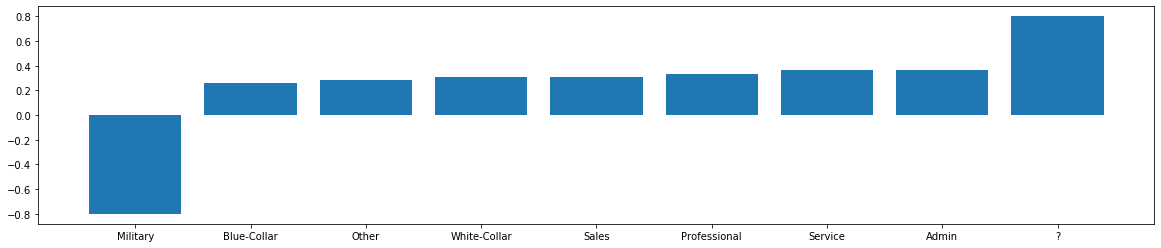

In [81]:
cat = 'Occupation'
idx = feature_names.index(cat)
plot_bar(cf.d_abs[idx], np.array(category_map[idx]), figsize=(20,4))

['Dropout' 'High School grad' 'Associates' 'Bachelors' 'Masters'
 'Prof-School' 'Doctorate']


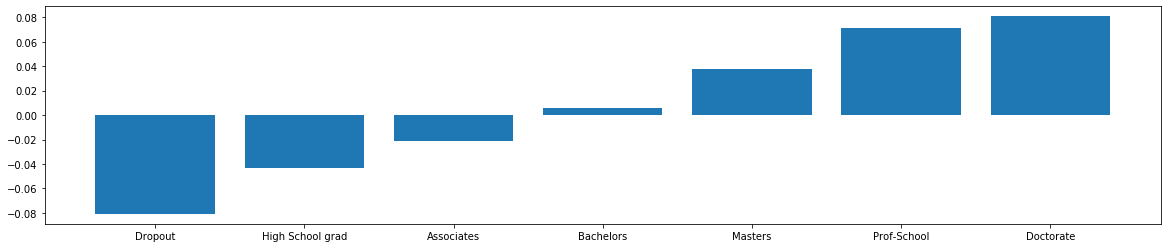

In [83]:
cat = 'Education'
idx = feature_names.index(cat)
plot_bar(cf.d_abs[idx], np.array(category_map[idx]), figsize=(20,4))

['Never-worked' '?' 'Private' 'State-gov' 'Local-gov' 'Federal-gov'
 'Self-emp-not-inc' 'Without-pay' 'Self-emp-inc']


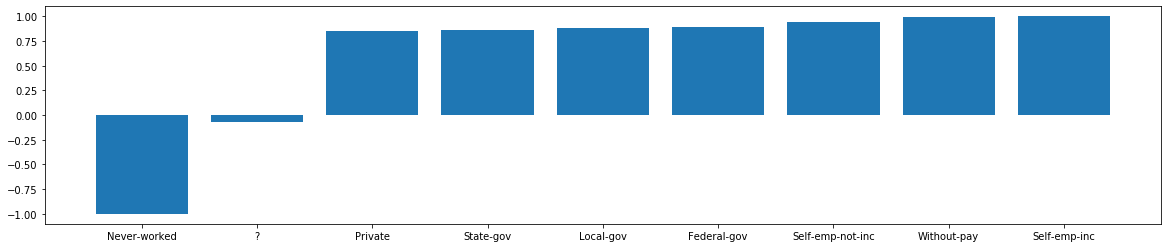

In [84]:
cat = 'Workclass'
idx = feature_names.index(cat)
plot_bar(cf.d_abs[idx], np.array(category_map[idx]), figsize=(20,4))

### To explain a specific instance and show the factors that can change to affect income

In [78]:
explanation = cf.explain(X)

In [79]:
def describe_instance(X, explanation, eps=1e-2):
    print('Original instance: {}  -- proba: {}'.format(target_names[explanation.orig_class],
                                                       explanation.orig_proba[0]))
    print('Counterfactual instance: {}  -- proba: {}'.format(target_names[explanation.cf['class']],
                                                             explanation.cf['proba'][0]))
    print('\nCounterfactual perturbations...')
    print('\nCategorical:')
    X_orig_ord = ohe_to_ord(X, cat_vars_ohe)[0]
    X_cf_ord = ohe_to_ord(explanation.cf['X'], cat_vars_ohe)[0]
    delta_cat = {}
    for i, (_, v) in enumerate(category_map.items()):
        cat_orig = v[int(X_orig_ord[0, i])]
        cat_cf = v[int(X_cf_ord[0, i])]
        if cat_orig != cat_cf:
            delta_cat[feature_names[i]] = [cat_orig, cat_cf]
    if delta_cat:
        for k, v in delta_cat.items():
            print('{}: {}  -->   {}'.format(k, v[0], v[1]))
    print('\nNumerical:')
    delta_num = X_cf_ord[0, -4:] - X_orig_ord[0, -4:]
    n_keys = len(list(cat_vars_ord.keys()))
    for i in range(delta_num.shape[1]):
        if np.abs(delta_num[0, i]) > eps:
            print('{}: {:.2f}  -->   {:.2f}'.format(feature_names[i+n_keys],
                                            X_orig_ord[0,i+n_keys],
                                            X_cf_ord[0,i+n_keys]))

In [80]:
describe_instance(X, explanation)

Original instance: <=50K  -- proba: [0.82661915 0.1733808 ]
Counterfactual instance: >50K  -- proba: [0.4627202 0.5372798]

Counterfactual perturbations...

Categorical:
Education: Associates  -->   Bachelors
Country: United-States  -->   Euro_1

Numerical:
Capital Gain: -1.00  -->   -0.99
